In [2]:
#import all the requirements
import numpy as np
import os
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K

### Checking the GPU enable for Training the Model

In [4]:
#checking the GPU
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


### Hyperparameters for the future model

In [5]:
INIT_LR = 1e-3
BATCH_SIZE = 16
EPOCHS = 100
IMAGE_SIZE = 256
default_image_size = tuple((IMAGE_SIZE, IMAGE_SIZE))
image_size = 0
data_dir = "../input/tomatoleaf/tomato/val"
CHANNELS=3
AUTOTUNE = tf.data.AUTOTUNE

In [6]:
#spliting the Dataset
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = ds.cardinality().numpy()

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [ ]:
#dataset spliting into training and testing
dataset = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  seed=123,
  image_size=default_image_size,
  batch_size=BATCH_SIZE
)


train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
#checking the avaiable classes
class_names = dataset.class_names
n_classes = len(class_names)
print(n_classes, class_names)

### Displaying the sample images from the dataset

2022-04-08 12:09:02.395256: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


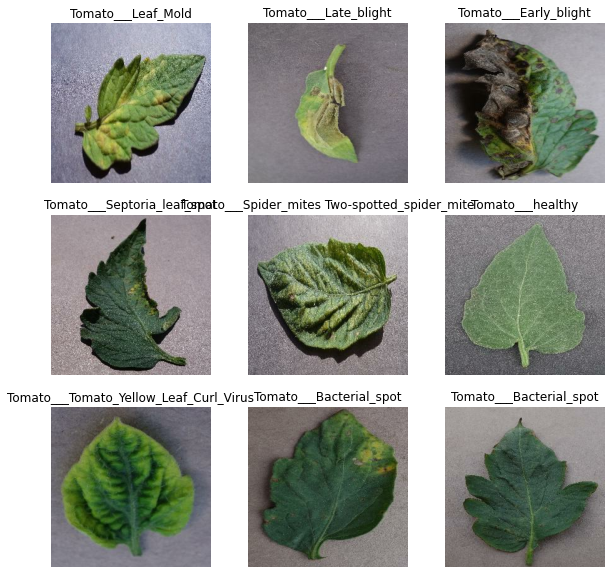

In [ ]:
#Displaying the sample images from the dataset
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
#checking the batch Size
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(16, 256, 256, 3)
(16,)


In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

## Creating a Layer for Resizing and Normalization

In [ ]:
#Creating a Layer for Resizing and Normalization
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

## Data Augmentation

In [ ]:
#Data Augmentation
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [ ]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
batch_input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
chanDim = -1
if K.image_data_format() == "channels_first":
    input_shape = (CHANNELS, IMAGE_SIZE, IMAGE_SIZE)
    batch_input_shape = (BATCH_SIZE, CHANNELS, IMAGE_SIZE, IMAGE_SIZE)
    chanDim = 1

# Build TensorFlow Model Architecture

In [ ]:
#CNN with softmax activation layer in last output layer
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=batch_input_shape)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (16, 256, 256, 3)         0         
_________________________________________________________________
sequential_1 (Sequential)    (16, 256, 256, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (16, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (16, 127, 127, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (16, 125, 125, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (16, 62, 62, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (16, 60, 60, 64)         

In [ ]:
#Compiling the Model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

# Training the model

In [ ]:
#Training the network
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/100


2022-04-08 12:09:12.742181: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


50/50 [==============================] - 11s 50ms/step - loss: 2.3029 - accuracy: 0.1023 - val_loss: 2.2914 - val_accuracy: 0.1458
Epoch 2/100
50/50 [==============================] - 1s 21ms/step - loss: 2.2930 - accuracy: 0.1098 - val_loss: 2.2639 - val_accuracy: 0.2083
Epoch 3/100
50/50 [==============================] - 1s 21ms/step - loss: 2.2206 - accuracy: 0.1742 - val_loss: 2.1106 - val_accuracy: 0.1667
Epoch 4/100
50/50 [==============================] - 1s 21ms/step - loss: 2.0089 - accuracy: 0.2121 - val_loss: 2.2231 - val_accuracy: 0.1771
Epoch 5/100
50/50 [==============================] - 1s 21ms/step - loss: 1.9009 - accuracy: 0.2525 - val_loss: 1.8577 - val_accuracy: 0.2500
Epoch 6/100
50/50 [==============================] - 1s 21ms/step - loss: 1.8000 - accuracy: 0.2866 - val_loss: 2.3773 - val_accuracy: 0.2292
Epoch 7/100
50/50 [==============================] - 1s 22ms/step - loss: 1.7031 - accuracy: 0.3384 - val_loss: 1.9020 - val_accuracy: 0.3125
Epoch 8/100
50/50

In [ ]:
#testing the CNN model
print("[INFO] Calculating model accuracy")
scores = model.evaluate(test_ds)
print(f"Test Accuracy: {round(scores[1],4)*100}%")

[INFO] Calculating model accuracy
7/7 [==============================] - 1s 8ms/step - loss: 0.3446 - accuracy: 0.8571
Test Accuracy: 85.71%


# Plotting the accuracy Graph

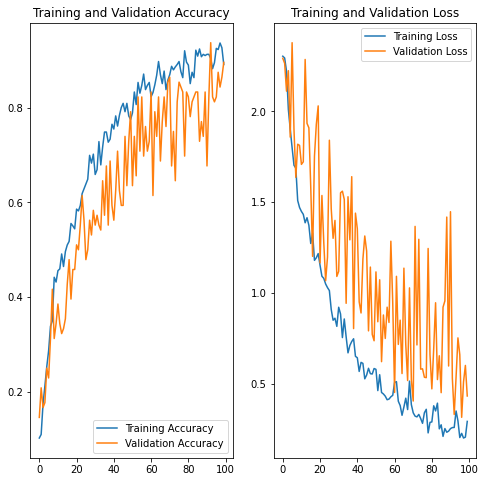

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
model.save("CNN.h5")

## Prediction function

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence


first image to predict
actual label: Tomato___Septoria_leaf_spot
predicted label: Tomato___Septoria_leaf_spot


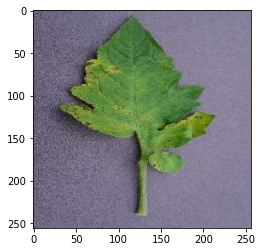

In [ ]:
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

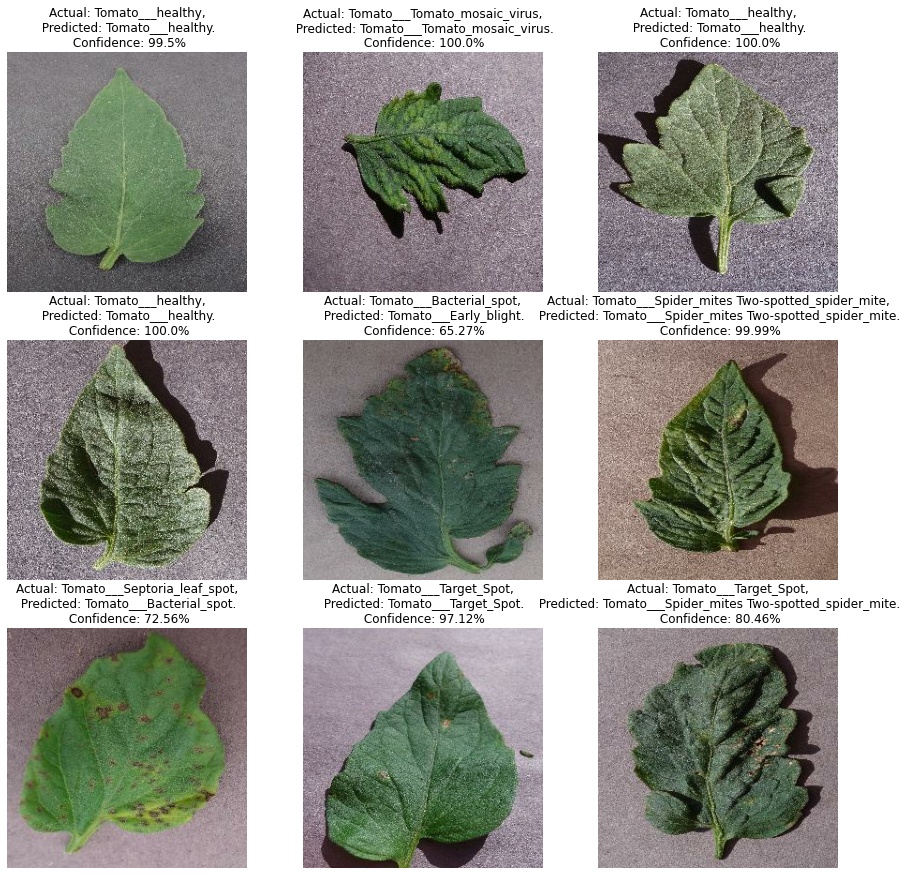

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy())

        actual_class = class_names[labels[i]]
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")

## Create a Quantization Aware Model

In [ ]:
#Create a Quantization Aware Model
!pip install --upgrade tensorflow-model-optimization
import tensorflow_model_optimization as tfmot

     |████████████████████████████████| 237 kB 568 kB/s            


### Quantize only the Dense, MaxPool2D, Conv2D Layers

In [ ]:
#Quantize only the Dense, MaxPool2D, Conv2D Layers
def apply_quantization(layer):
    if (
        isinstance(layer, layers.Dense)
        or isinstance(layer, layers.MaxPool2D)
        or isinstance(layer, layers.Conv2D)
    ):
        return tfmot.quantization.keras.quantize_annotate_layer(layer)
    return layer

In [ ]:
annotated_model = tf.keras.models.clone_model(
    model,
    clone_function=apply_quantization,
)

quant_aware_model = tfmot.quantization.keras.quantize_apply(annotated_model)
quant_aware_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 256, 256, 3)       0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 256, 256, 3)       0         
_________________________________________________________________
quant_conv2d (QuantizeWrappe (None, 254, 254, 32)      963       
_________________________________________________________________
quant_max_pooling2d (Quantiz (None, 127, 127, 32)      1         
_________________________________________________________________
quant_conv2d_1 (QuantizeWrap (None, 125, 125, 64)      18627     
_________________________________________________________________
quant_max_pooling2d_1 (Quant (None, 62, 62, 64)        1         
_________________________________________________________________
quant_conv2d_2 (QuantizeWrap (None, 60, 60, 64)       

In [ ]:
#Finr Tuning the model
quant_aware_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
q_history = quant_aware_model.fit(train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=25,
)

Epoch 1/25
50/50 [==============================] - 4s 42ms/step - loss: 0.3082 - accuracy: 0.8977 - val_loss: 0.4991 - val_accuracy: 0.8542
Epoch 2/25
50/50 [==============================] - 2s 37ms/step - loss: 0.3320 - accuracy: 0.8826 - val_loss: 1.0621 - val_accuracy: 0.7188
Epoch 3/25
50/50 [==============================] - 2s 37ms/step - loss: 0.2136 - accuracy: 0.9331 - val_loss: 0.7150 - val_accuracy: 0.8438
Epoch 4/25
50/50 [==============================] - 2s 42ms/step - loss: 0.2780 - accuracy: 0.9066 - val_loss: 0.5792 - val_accuracy: 0.8542
Epoch 5/25
50/50 [==============================] - 2s 38ms/step - loss: 0.2170 - accuracy: 0.9192 - val_loss: 0.5011 - val_accuracy: 0.8438
Epoch 6/25
50/50 [==============================] - 2s 37ms/step - loss: 0.4029 - accuracy: 0.8535 - val_loss: 0.6490 - val_accuracy: 0.7917
Epoch 7/25
50/50 [==============================] - 2s 37ms/step - loss: 0.2396 - accuracy: 0.9205 - val_loss: 0.4753 - val_accuracy: 0.8438
Epoch 8/25
50

## Testing the accuracy of the model


In [ ]:
#Testing the accuracy after Fine tunning
print("[INFO] Calculating Quant Aware model accuracy")
scores = quant_aware_model.evaluate(test_ds)
print(f"Test Accuracy: {round(scores[1],4)*100}%")

[INFO] Calculating Quant Aware model accuracy
7/7 [==============================] - 0s 12ms/step - loss: 0.4385 - accuracy: 0.8571
Test Accuracy: 85.71%


## Saving the fine tunning model

In [ ]:
#saving the fine tunning model
import os
model.save("CNN.h5")